# Cumulative erosion

This notebook fits a parametric (gamma) distribution to the cumulative erosion values extracted from the landscape evolution model.

If training data has been extracted from the source datasets by running the `00c-extract_training_data_global.ipynb` and `00b-extract_grid_data.ipynb` notebooks, set the `use_extracted_data` variable below to `True` to use this dataset instead of the pre-prepared training data from the [Zenodo repository](https://zenodo.org/record/8157691).

## Notebook options

These cells set some of the important variables and definitions used throughout the notebook.

In [1]:
# If True, use training data extracted in notebook 00c
# Else, use pre-prepared training data downloaded from Zenodo
use_extracted_data = True

# Number of processes to use
n_jobs = 4

# Timespan for analysis
min_time = 0
max_time = 170

# Remove outliers before fitting distribution (this value usually works fairly well)
outlier_contamination = 0.06

# Control randomness by setting random_state to a constant
random_state = 1234

# Control verbosity level of logging output
verbose = False

These values will usually not need to be modified:

In [2]:
from lib.check_files import check_prepared_data

if use_extracted_data:
    data_dir = "extracted_data"
else:
    data_dir = check_prepared_data("prepared_data", verbose=True)

output_dir = "outputs"

dist_name = "gengamma"
failure = "raise"  # or "ignore"

gengamma_bounds = {
    "a": (0, 50),
    "c": (-50, 50),
}

If any of the following exist as environment variables, they will replace the values defined above:

In [3]:
import os

n_jobs = int(os.environ.get("N_JOBS", n_jobs))
min_time = int(os.environ.get("MIN_TIME", min_time))
max_time = int(os.environ.get("MAX_TIME", max_time))
random_state = int(os.environ.get("RANDOM_STATE", random_state))
outlier_contamination = float(os.environ.get("OUTLIER_CONTAMINATION", outlier_contamination))
verbose = bool(int(os.environ.get("VERBOSE", verbose)))

## Notebook setup

Imports, definitions, etc.

### Imports

In [4]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import dump
from scipy.optimize import differential_evolution
from scipy.stats import (
    fit,
    gengamma,
)

from lib.erodep import clean_outliers

### Input and output files

In [5]:
data_filename = os.path.join(data_dir, "training_data_global.csv")

output_dir = os.path.join(output_dir, "global")
output_parametric = os.path.join(output_dir, "erodep_dist.joblib")
output_hist = os.path.join(output_dir, "erodep_dist.png")
output_scatter = os.path.join(output_dir, "erodep_scatter.png")

## Load data and fit distribution

The distribution will be saved as a `.joblib` file in the output directory.

In [6]:
df = pd.read_csv(data_filename)
df = df[
    (df["age (Ma)"] <= max_time)
    & (df["age (Ma)"] >= min_time)
]
positives = df[df["label"] == "positive"]
unlabelled = df[df["label"] == "unlabelled"]

x_positives = np.array(positives["erosion (m)"])
x_unlabelled = np.array(unlabelled["erosion (m)"])

In [7]:
x_cleaned = clean_outliers(
    data=x_positives,
    contamination=outlier_contamination,
    n_jobs=n_jobs,
    random_state=random_state,
)
x_cleaned = x_cleaned[x_cleaned > 0.0]

In [8]:
def optimize_func(*args, **kwargs):
    return differential_evolution(*args, seed=random_state, **kwargs)


with warnings.catch_warnings():
    warnings.simplefilter("ignore", RuntimeWarning)
    fitted_params = fit(
        gengamma,
        data=x_cleaned,
        bounds=gengamma_bounds,
        optimizer=optimize_func,
    )
if not fitted_params.success:
    message = f"Optimisation failed! {fitted_params.message}"
    if failure == "raise":
        raise RuntimeError(message)
    else:
        warnings.warn(message, RuntimeWarning)

dist_parametric = gengamma(*(fitted_params.params))
nll_parametric = -1 * dist_parametric.logpdf(x_cleaned).sum()

dump(dist_parametric, output_parametric, compress=True)
if verbose:
    print(f"Parametric (gamma) distribution: NLL = {nll_parametric:0.0f}")
    print(
        f"""Writing parametric distribution to file: {output_parametric}"""
    )

## Plots

Plots will be saved to the output directory.

### Distribution plot

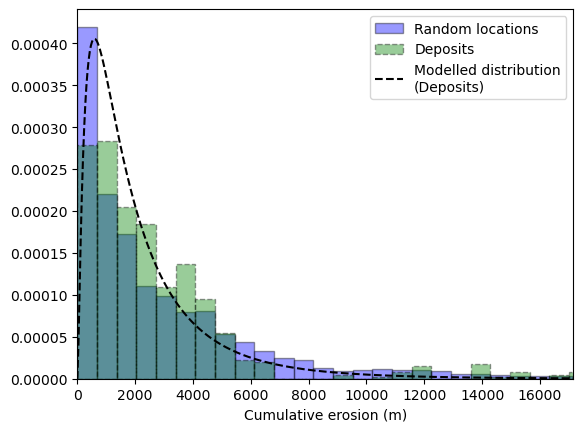

In [9]:
dist_x = np.linspace(
    positives["erosion (m)"].min(),
    positives["erosion (m)"].max(),
    500,
)
y_parametric = dist_parametric.pdf(dist_x)

fig, ax = plt.subplots()
nbins = 30
_, bins, _ = ax.hist(
    unlabelled["erosion (m)"],
    bins=nbins,
    density=True,
    facecolor="blue",
    alpha=0.4,
    label="Random locations",
    linestyle="solid",
    edgecolor="black",
    linewidth=1,
)
ax.hist(
    positives["erosion (m)"],
    bins=bins,
    density=True,
    facecolor="green",
    alpha=0.4,
    label="Deposits",
    linestyle="dashed",
    edgecolor="black",
    linewidth=1,
)
ax.plot(
    dist_x,
    y_parametric,
    linestyle="dashed",
    color="black",
    zorder=10,
    label="Modelled distribution\n(Deposits)",
    linewidth=1.5,
)

ax.set_xlabel("Cumulative erosion (m)")
ax.set_xlim(0, positives["erosion (m)"].quantile(0.99))
ax.legend(loc="best")
fig.savefig(output_hist, dpi=400, bbox_inches="tight")

### Scatter plot

Plot deposit age v. cumulative erosion, grouped by region.

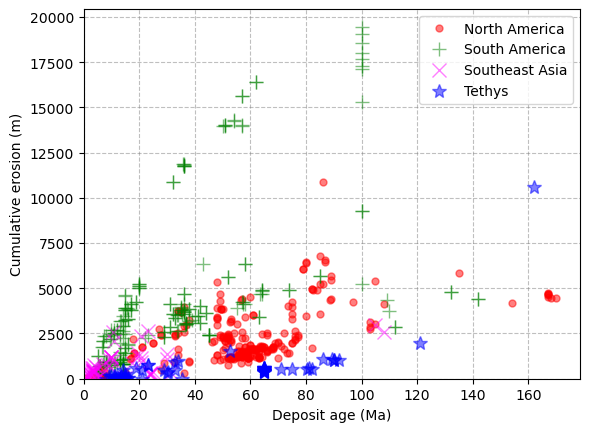

In [10]:
kw = {
    "North America": {
        "color": "red",
        "marker": ".",
    },
    "South America": {
        "color": "green",
        "marker": "+",
    },
    "Southeast Asia": {
        "color": "magenta",
        "marker": "x",
    },
    "Tethys": {
        "color": "blue",
        "marker": "*",
    },
}

fig, ax = plt.subplots()
for region, subset in positives.groupby("region"):
    if region not in kw.keys():
        continue
    ax.plot(
        "age (Ma)",
        "erosion (m)",
        linestyle="none",
        data=subset,
        label=region,
        alpha=0.5,
        markersize=10,
        **(kw[region]),
    )

ax.legend()
ax.set_xlabel("Deposit age (Ma)")
ax.set_ylabel("Cumulative erosion (m)")
ax.set_xlim(0, None)
ax.set_ylim(0, None)
ax.grid(linestyle="dashed", color="grey", alpha=0.5)
fig.savefig(output_scatter, dpi=400, bbox_inches="tight")